<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture01_test_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Lecture 01.CNN** 

# 01. 라이브러리 불러오기


In [1]:
import numpy as np
import os, matplotlib
from matplotlib import pyplot as plt

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils

# 데이터 로딩

In [2]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')
print(x_train.shape, y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


In [3]:
x_train_list=[] 
x_test_list=[]
for i, i_ in enumerate(x_train[:60000]):
  arr = np.zeros(shape=(32,32))
  arr[:28,:28] = x_train[i]
  x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
  arr = np.zeros(shape=(32,32))
  arr[:28,:28] = x_test[i]
  x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(60000, 32, 32, 1) (500, 32, 32, 1)


In [4]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:60000]):
  zero = [0]*10
  zero[i_] = 1
  y_train_list.append(zero)
for i, i_ in enumerate(y_test[:500]):
  zero = [0]*10
  zero[i_] = 1
  y_test_list.append(zero)

y_train1 = np.array(y_train_list)
y_test1= np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(60000, 10) (500, 10)


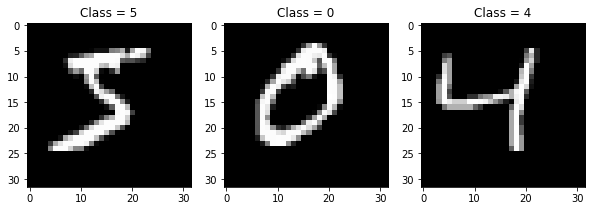

In [5]:
plt.figure(figsize=(10,10))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(x_train1[i][...,0], cmap = 'gray')
  plt.title('Class = {}'.format(y_train[i]))

# 3. 모델 만들기

# AI 모델을 구성하는 레이어 만들기

 AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다. 가장 대표적인 레이어 구조인 CONV-BN-ACT-POOL 구조를 만들어 보겠습니다.

 먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [6]:
first_layer = Input(shape=(32,32,1))

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [12]:
second_layer = layers.Conv2D(filters=8, kernel_size=(3,3), activation = None, padding = 'same')(first_layer)

In [13]:
third_layer = layers.Conv2D(filters=16, kernel_size=(3,3), activation = None, padding = 'same')(second_layer)

 다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다. 다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [14]:
fourth_layer = layers.BatchNormalization()(third_layer)

 Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [15]:
fifth_layer = layers.Activation('relu')(fourth_layer)

 다음으로 이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [16]:
sixth_layer = layers.MaxPool2D(strides=(2,2))(fifth_layer)

 그 후 모든 뉴런을 일렬로 늘어세우는 Flatten 레이어를 만듭니다.

In [17]:
seventh_layer = layers.Flatten()(sixth_layer)

 일렬로 늘어세운 후 이전 계층의 모든 뉴런을 연결해주는 Fully connected(Dense) 레이어를 연결합니다.

In [18]:
eighth_layer = layers.Dense(100, activation = 'relu')(seventh_layer)

  Dropout 레이어를 활용해 일부 뉴런들을 무작위로 학습에서 배제하도록 합시다.

In [19]:
nineth_layer = layers.Dropout(0.25)(eighth_layer)

 마지막으로 최종 결과물을 출력해주는 레이어를 만들어 줍니다.

In [20]:
final_layer = layers.Dense(10, activation = 'sigmoid')(nineth_layer)

 지금까지 만든 레이어를 Model 함수에 넣어 연결하면 모델이 완성됩니다.

In [21]:
model = Model(first_layer, final_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0     

# 4. 모델 훈련하기

신경망 모델의 손실함수와 옵티마이저, 학습률 등의 파라미터를 지정해줍니다.

성능은 정확도를 평가할 것입니다.

In [22]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

In [23]:
history = model.fit(x_train1, y_train1, epochs=20, batch_size=32, validation_data=(x_test1, y_test1), shuffle=True)

Epoch 1/20
1875/1875 [==============================] - 12s 3ms/step - loss: 0.5915 - accuracy: 0.8171 - val_loss: 0.0827 - val_accuracy: 0.9720
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1331 - accuracy: 0.9601 - val_loss: 0.0611 - val_accuracy: 0.9800
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0856 - accuracy: 0.9745 - val_loss: 0.0489 - val_accuracy: 0.9780
Epoch 4/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0658 - accuracy: 0.9798 - val_loss: 0.0291 - val_accuracy: 0.9940
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.0337 - val_accuracy: 0.9900
Epoch 6/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0450 - accuracy: 0.9860 - val_loss: 0.0219 - val_accuracy: 0.9920
Epoch 7/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0410 - accuracy: 0.9868 - val_loss: 0.0238 - val_accuracy

# 결과 확인하기

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
epochs = range(1,len(acc)+1)

 정확도와 손실함수 그래프 그리기

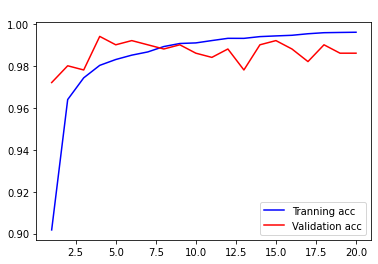

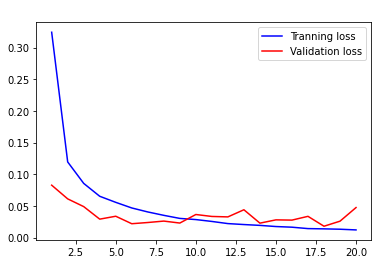

In [27]:
plt.plot(epochs, acc, 'b', color='blue', label='Tranning acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Tranning and validation accuracy', color='w')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Tranning loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Tranning and validation loss', color='w')
plt.legend()

plt.show()